# Author network
This notebook explores building a network with authors as nodes instead of papers, using both co-authorships and citations as edges/weights.

In [1]:
import networkx as nx
import jsonlines
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import combinations, permutations
from networkx.algorithms.community.louvain import louvain_communities, louvain_partitions

## Read & pre-process data

In [2]:
graph = nx.read_graphml('../../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

In [3]:
with jsonlines.open('../../data/wos_files/core_collection_destol_or_anhydro_ALL_with_authors_18Jan2024_parallel.jsonl') as reader:
    papers = [obj for obj in reader]

In [4]:
# Index by paper
paper_authors = defaultdict(list)
for paper in papers:
    uid = paper['UID']
    for author in paper['authors']:
        try:
            paper_authors[uid].append(author['wos_standard'])
        except KeyError:
            continue

In [5]:
# Index by author
author_papers = defaultdict(list)
for paper in papers:
    uid = paper['UID']
    for author in paper['authors']:
        try:
            author_papers[author['wos_standard']].append(uid)
        except KeyError:
            continue

In [6]:
print(f'There are {len(author_papers)} unique author names in the dataset.')

There are 18036 unique author names in the dataset.


Text(0, 0.5, 'Frequency')

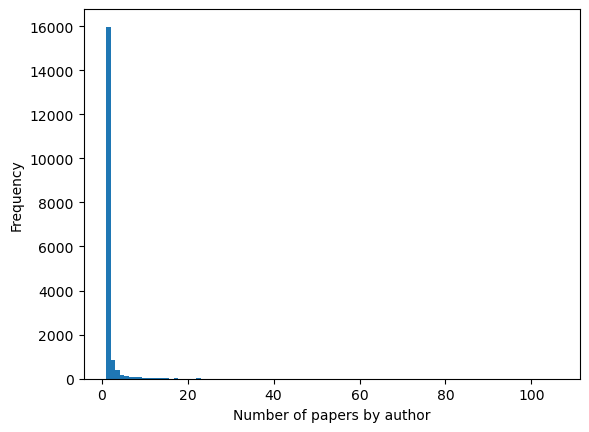

In [7]:
paper_nums = [len(v) for k,v in author_papers.items()]
_ = plt.hist(paper_nums, bins=100)
plt.xlabel('Number of papers by author')
plt.ylabel('Frequency')

In [8]:
cutoff = 3
print(f'{100*(len([i for i in paper_nums if i > cutoff])/len(paper_nums)):.2f} percent of authors have more than {cutoff} papers.')

6.75 percent of authors have more than 3 papers.


We'll remove authors with fewer than 3 papers from the dataset for the sake of building the people network, as it'll greatly simplify the resulting visuals and will make them more meaningful.

In [9]:
thresholded = {k:v for k,v in author_papers.items() if len(v) > cutoff}
print(f'There are {len(thresholded)} authors remaining in the dataset.')

There are 1218 authors remaining in the dataset.


## Building people network
There are two kinds of links we'll consider in our network building; co-authorships, and citations. .

### Co-author network

In [10]:
co_authorship_weights = defaultdict(int)
for paper in papers:
    authors = []
    for author in paper['authors']:
        try:
            if author['wos_standard'] in thresholded.keys():
                authors.append(author['wos_standard'])
        except KeyError:
            continue
    all_author_pairs = combinations(authors, 2)
    for author_pair in all_author_pairs:
        if author_pair[0] != author_pair[1]:
            co_authorship_weights[author_pair] += 1
# Combine reverse-ordered pair counts for edges
co_author_joined_weights = defaultdict(int)
for pair, val in co_authorship_weights.items():
    co_author_joined_weights[tuple(set(pair))] += val
edges = [(c[0], c[1], {'weight': w}) for c, w in co_author_joined_weights.items()]

In [11]:
co_author_graph = nx.Graph()
_ = co_author_graph.add_edges_from(edges)

In [12]:
comms = list(louvain_communities(co_author_graph, seed=1234))
parts = list(louvain_partitions(co_author_graph, seed=1234))

In [180]:
len(co_author_graph.nodes)

1171

In [179]:
sum([len(comm) for comm in comms])

1171

In [213]:
class GenericTreeNode():
    """
    Class to store node of a generic tree.
    """
    def __init__(self, ident):
        """
        Initialize GenericTreeNode instance.
        """
        self.ident = ident
        self.children = None

    def parse_children(self, parts, i):
        """
        Parse a tree formatted as nested lists with leaf node ID's contained in sets
        """
        # Base case
        if isinstance(parts, set):
            self.children = [GenericTreeNode(c) for c in parts]
        # Recursive case
        else:
            self.children = []
            for part in parts:
                c_node = GenericTreeNode(i)
                c_node.parse_children(part, i)
                i += 1
                self.children.append(c_node)

    @staticmethod
    def get_node_path(root, n, path, paths):
        """
        Get the list of ID's from this node to a leaf node n.

        parameters:
            root, GenericTreeNode instance: node from which to search
            n, str: node ID
            path, list of str: list of node IDs
            path, list of list: paths

        returns:
            path, list of str: list of node ID's on the path
        """
        # Base case
        if root.children is None:
            if n == root.ident:
                path.append(n)
                paths.append(path)
                print('paths object in base case: ', paths)
                return path, paths
        # Recursive case
        else:
            path.append(root.ident)
            for child in root.children:
                GenericTreeNode.get_node_path(child, n, list(path), paths)
                

    def get_distances(self, n1, n2):
        """
        Get the traversal distance between two nodes. Assumes the self node
        is the tree root.

        parameters:
            n1, n2, str: the identifier strings for the nodes of interest

        returns:
            dist, int: number of steps between n1 and n2
        """
        pass
        

In [214]:
tree = GenericTreeNode('root')
tree.parse_children(parts, 0)

In [215]:
GenericTreeNode.get_node_path(tree, 'Heyer, AG', [], [])

paths object in base case:  [['root', 0, 0, 'Heyer, AG']]
paths object in base case:  [['root', 0, 0, 'Heyer, AG'], ['root', 1, 14, 'Heyer, AG']]
paths object in base case:  [['root', 0, 0, 'Heyer, AG'], ['root', 1, 14, 'Heyer, AG'], ['root', 2, 9, 'Heyer, AG']]


In [36]:
len(parts)

3

In [17]:
tree.children

AttributeError: 'NoneType' object has no attribute 'children'

In [36]:
comm_ids = {i: comm for i, comm in enumerate(comms)}
bottom = False
part_check = parts
levels = 0
while not bottom:
    if isinstance(part_check, set):
        levels += 1
        bottom = True
    else:
        levels += 1
        part_check = part_check[1]
print(levels)

3


In [38]:
part_ids = {}
for num in levels:
    part_level_0_ids = {i: part for i, part in enumerate(parts)}
len(part_level_0_ids)

3

In [33]:
q.pop()

[{'Benoit, JB',
  'Capece, A',
  'Cordero-Otero, R',
  'Davies, SA',
  'Denlinger, DL',
  'Dow, JAT',
  'Elnitsky, MA',
  'Gantz, JD',
  'Goto, SG',
  'Kawarasaki, Y',
  'Kimura, MT',
  'Lee, RE',
  'Lopez-Martinez, G',
  'Marley, R',
  'Nachman, RJ',
  'Numata, H',
  'Philip, BN',
  'Renault, D',
  'Rinehart, JP',
  'Rodriguez-Porrata, B',
  'Romano, P',
  'Rosendale, AJ',
  'Rozes, N',
  'Teets, NM',
  'Terhzaz, S',
  'Vannier, G',
  'Williams, JB',
  'Yi, SX',
  'Yoder, JA'},
 {'Arribas, P', 'Botella-Cruz, M', 'Millan, A', 'Pallares, S', 'Velasco, J'},
 {'Adkins, SW',
  'Artur, MAS',
  'Ashmore, SE',
  'Bentsink, L',
  'Bino, RJ',
  'Coelho, SVB',
  'Costa, MCD',
  'Cueff, G',
  'Davide, AC',
  'Dekkers, BJW',
  'Dulloo, ME',
  'Faria, JMR',
  'Fogliani, B',
  'Groot, SPC',
  'Guarino, L',
  'Guimaraes, CC',
  'Hilhorst, H',
  'Hilhorst, HWM',
  'Job, C',
  'Job, D',
  'Jose, AC',
  'Koornneef, M',
  'Ligterink, W',
  'Lipavska, H',
  'Maia, J',
  'Masetto, TE',
  'McDonald, MB',
  

In [28]:
for part in parts:
    print(f'Len level 0 community: {len(part)}')
    print(part)
    for p in part:
        print(f'Len level 1 community: {len(p)}')
        print(p)

Len level 0 community: 220
[{'Heyer, AG', 'Zuther, E', 'Popova, AV', 'Hundertmark, M', 'Hincha, DK', 'Fujikawa, S'}, {'Verdier, J', 'Leprince, O', 'Chatelain, E', 'Rogniaux, H', 'Seo, M', 'Pelletier, S', 'Lalanne, D', 'Satour, P', 'Vu, BL', 'Buitink, J', 'Bolingue, W', 'Righetti, K', 'Malabarba, J'}, {'Benamar, A', 'Macherel, D', 'Avelange-Macherel, MH', 'Tolleter, D'}, {'Jing, XM', 'Xin, X', 'Lin, J'}, {'Rosendale, AJ', 'Elnitsky, MA', 'Gantz, JD', 'Kawarasaki, Y', 'Philip, BN', 'Benoit, JB', 'Renault, D', 'Williams, JB', 'Yi, SX', 'Lee, RE', 'Teets, NM', 'Lopez-Martinez, G', 'Vannier, G', 'Numata, H', 'Yoder, JA', 'Kimura, MT', 'Denlinger, DL', 'Goto, SG', 'Rinehart, JP'}, {'Li, W', 'Duan, DL'}, {'Scott, P', 'Toldi, O'}, {'Velasco, J', 'Botella-Cruz, M', 'Arribas, P', 'Millan, A', 'Pallares, S'}, {'Groot, SPC', 'Bino, RJ', 'Vreugdenhil, D', 'Lipavska, H', 'Koornneef, M'}, {'Taylor, AG', 'John, P', 'Hong, TD', 'Hay, FR', 'Black, M', 'Ellis, RH', 'Murdoch, AJ', 'Sinniah, UR', 'Osborne,

In [23]:
[len(comm) for comm in comms]

[29,
 5,
 45,
 70,
 59,
 96,
 127,
 3,
 15,
 4,
 4,
 2,
 97,
 8,
 2,
 27,
 2,
 2,
 23,
 6,
 2,
 12,
 8,
 32,
 68,
 11,
 36,
 49,
 16,
 2,
 2,
 49,
 2,
 33,
 2,
 7,
 2,
 3,
 2,
 8,
 12,
 5,
 3,
 3,
 34,
 2,
 2,
 23,
 11,
 3,
 2,
 2,
 2,
 13,
 2,
 2,
 2,
 2,
 2,
 72]

In [13]:
nx.write_graphml(co_author_graph, '../data/citation_network/co_author_graph_thresh_3_26Jan2023.graphml')

### Citation network

In [21]:
co_citation_weights = defaultdict(int)
for edge in graph.edges:
    for author1 in paper_authors[edge[0]]:
        for author2 in paper_authors[edge[1]]:
            if author1 != author2:
                if (author1 in thresholded.keys()) and (author2 in thresholded.keys()):
                    author_pair = tuple(set([author1, author2]))
                    co_citation_weights[author_pair] += 1
edges = [(e[0], e[1], {'weight': w}) for e, w in co_citation_weights.items()]

In [22]:
co_citation_graph = nx.Graph()
_ = co_citation_graph.add_edges_from(edges)

In [23]:
nx.write_graphml(co_citation_graph, '../data/citation_network/co_citation_graph_thresh_3_26Jan2023.graphml')